## //TODO: Get Y Labels
#### You should probably do this in API.py, so that there can be a different method you call from this cell which chooses tickers, calls getSamples to retrieve the requested X data, selects the samples we want from the X data, and then calculates Y using the <date> in X

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import imp

from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler

import statsmodels.tsa.api as tsa
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

from api_keys import fmp_api_key as api_key
# from API import API
import API
imp.reload(API)
from API import API


api = API(api_key, period='quarter', limit=None)
tickers = api.getRandTickers(50)
# tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'JPM', 'JNJ']

X = api.getSamplesFromTickers(tickers, samplesPerTicker=20, maxTickers=50)
Y = api.getYFromDF(X)


Making API call request...

Getting X data...
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request

In [2]:
print(api.getNumApiCalls())

121


## Format X and Y Data

In [3]:
print(tickers)

baselinePercentage = .06
Y['baselinePercentage'] = Y.apply(lambda row: baselinePercentage, axis=1)

merged = pd.merge(X, Y, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"]).dropna()

['ARCHIDPLY.NS', 'MRKV.ME', 'JAKK', 'STCM.L', 'PRECWIRE.NS', 'IBULHSGFIN.NS', 'LYTS', 'DTGI', 'DXQLX', 'KBH', 'CDE', 'Z', 'GSC1.DE', 'TGVAX', '2086.HK', 'DEZU', 'EDE.AX', 'EASG', 'PPE.AX', 'KZOS.ME', 'MBEYX', 'FCCO', 'POGRX', 'TOTB.DE', 'DSCV.L', 'ZEAL', 'DMART.NS', 'LSMG', 'NYMTN', 'HSCL.NS', 'ELIS.PA', 'CONFIPET.NS', 'TFIV', 'ISBC', 'VOX', 'ALKYLAMINE.NS', 'BLVAX', 'MP', 'NDM.TO', 'HDB', 'YAR.OL', 'AUTOLITIND.NS', 'DDLS', '1750.HK', 'SNUG', 'LANDM', 'ORCH.L', 'ELGIEQUIP.NS', 'GSK', 'VCIP.TO']


In [4]:
X = merged.drop(['date', 'symbol', 'futureDate', 'futureClose', 'percentage', 'baselinePercentage'], axis=1)
Y = merged[['percentage']]
Y_baseline = merged[['baselinePercentage']]

In [5]:
# display(merge)
display(X.head())
print(X.columns)
print(X.shape)
display(Y.head())
print(Y.shape)
display(Y_baseline.head())
print(Y_baseline.shape)
print("Y decsribed:")
print(Y.describe())

,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,...,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,2.280702,1.078947,0.345745,0.058511,0.014320,0.032258,0.036066,1.252688,1.175488,1.162983,...,1.016393,0.203704,-0.263692,0.421053,-0.250000,-0.312500,-1.176471,-1.156863,2.186407e+07,3.216407e+07
1,1.863309,0.956835,0.346341,0.043902,0.008475,0.017094,0.027027,1.017094,1.195983,1.365171,...,0.063492,0.163934,0.061735,0.033333,1.000000,8.000000,-3.000000,-2.750000,2.798601e+07,3.558601e+07
2,3.354932,1.457455,0.285717,0.101176,0.023847,0.030965,0.045869,0.298455,2.056101,4.148793,...,0.043782,0.203376,0.109214,0.073782,0.404372,0.543054,0.540177,0.539708,2.660040e+08,2.778760e+08
3,4.358703,2.256271,0.195296,-0.007991,-0.014603,-0.017231,-0.003934,0.180006,1.198391,2.397120,...,0.006192,-0.223211,-0.183465,-0.026543,-0.742055,-1.187645,-2.338798,-2.338633,1.703921e+08,1.558931e+08
4,3.756850,2.012668,0.237582,0.035273,0.010836,0.013060,0.019715,0.205193,1.439331,2.553728,...,0.134249,0.297638,0.109827,0.169924,0.632834,2.470660,1.296798,1.294252,2.055393e+08,1.961793e+08


Index(['currentRatio', 'quickRatio', 'grossProfitMargin',
       'operatingProfitMargin', 'returnOnAssets', 'returnOnEquity',
       'returnOnCapitalEmployed', 'debtEquityRatio', 'priceToBookRatio',
       'priceToSalesRatio', 'priceEarningsRatio', 'priceEarningsToGrowthRatio',
       'priceToOperatingCashFlowsRatio', 'growthRevenue',
       'growthCostOfRevenue', 'growthGrossProfit', 'growthGrossProfitRatio',
       'growthOperatingExpenses', 'growthEBITDA', 'growthOperatingIncome',
       'growthNetIncome', 'growthEPS', 'marketCapitalization',
       'enterpriseValue'],
      dtype='object')
(152, 24)


,percentage
0,0.542857
1,-0.166667
2,-0.151852
3,0.236805
4,-0.280806


(152, 1)


,baselinePercentage
0,0.06
1,0.06
2,0.06
3,0.06
4,0.06


(152, 1)
Y decsribed:
       percentage
count  152.000000
mean     0.173565
std      0.594194
min     -0.821862
25%     -0.197922
50%      0.075381
75%      0.456320
max      3.964539


## Plot Features to Examine Distributions

<ipython-input-6-82ac20f67b5e>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


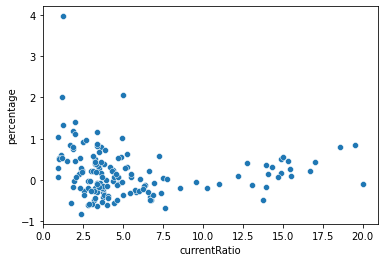

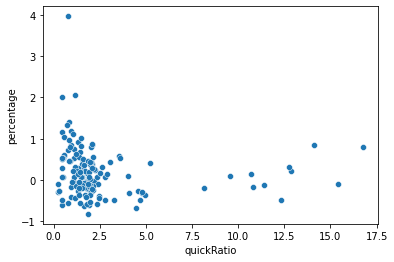

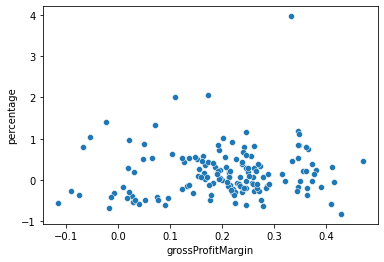

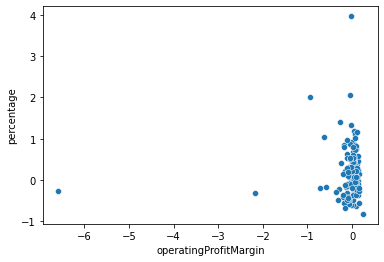

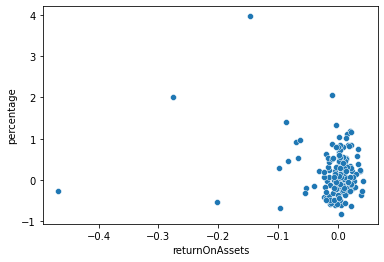

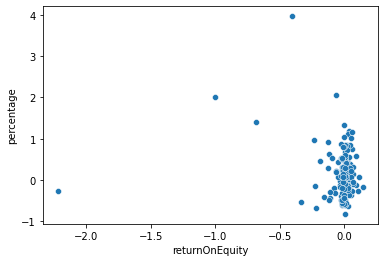

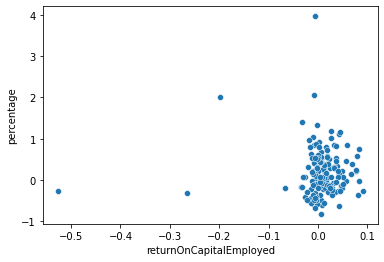

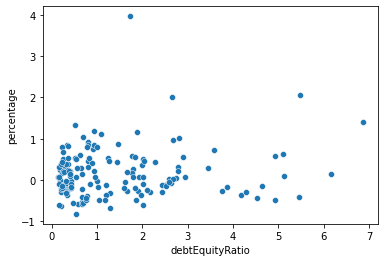

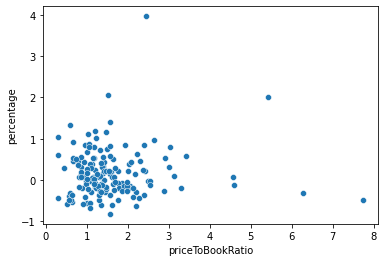

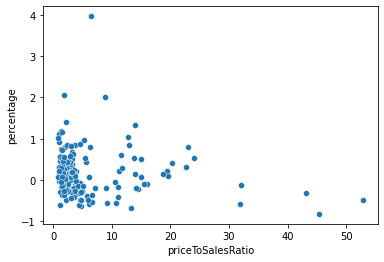

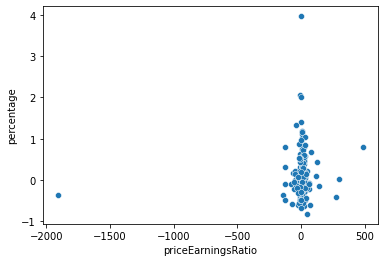

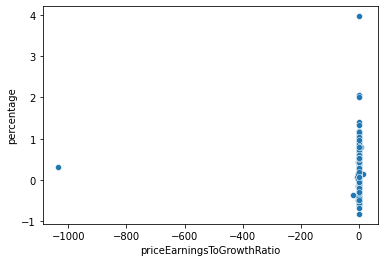

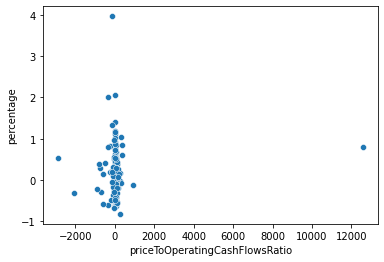

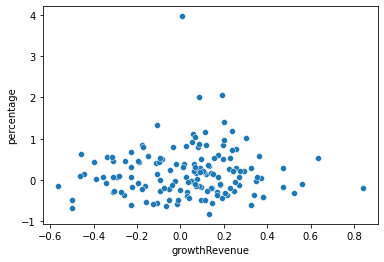

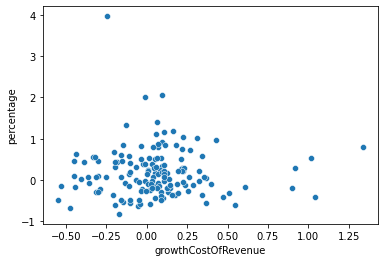

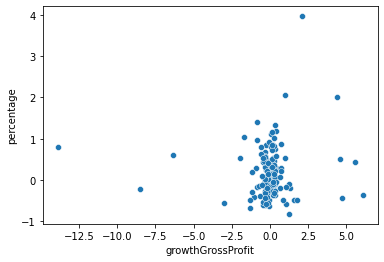

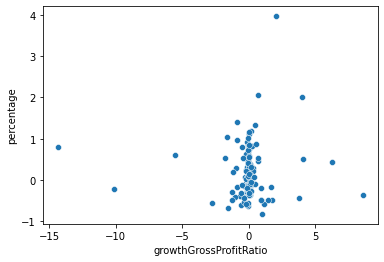

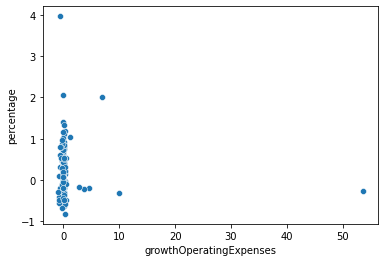

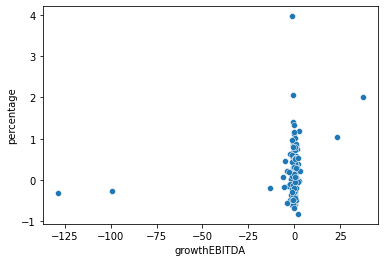

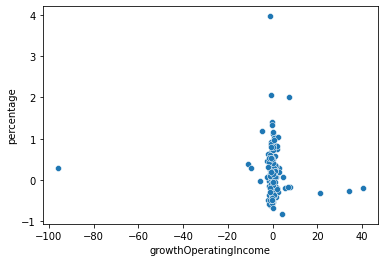

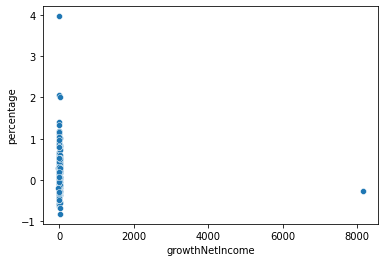

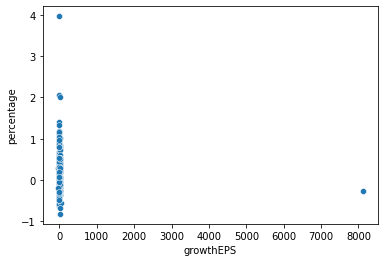

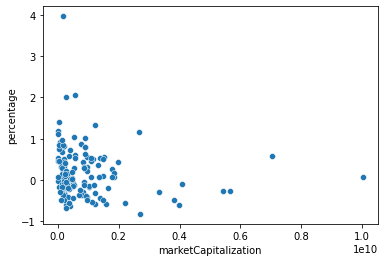

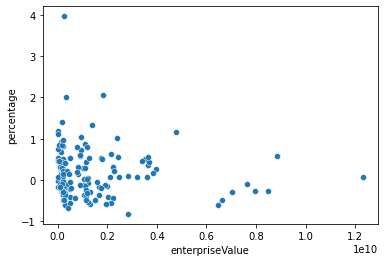

In [6]:
# plt.figure()
for colName in X:
  plt.figure()
  sns.scatterplot(data=merged, x=colName, y='percentage')

## Scaling/ Normalization

In [7]:
# min_max_scaler = MinMaxScaler((-1, 1))
# df[percentages] = min_max_scaler.fit_transform(df[percentages])  # No need, because percentages are already on a good scale
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X), columns = X.columns)
display(X_scaled.head())



,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,...,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,-0.728721,-0.477355,1.212897,0.226870,0.397780,0.292027,0.514897,-0.142012,-0.416400,-0.626328,...,3.352576,0.126169,-0.110277,-0.019118,0.086798,-0.028449,-0.082114,-0.082185,-0.624559,-0.660123
1,-0.825522,-0.518531,1.218014,0.201684,0.288818,0.221515,0.359474,-0.308856,-0.396114,-0.602050,...,0.053201,0.104099,0.061511,-0.105973,0.178171,0.868100,-0.084882,-0.084615,-0.619861,-0.658367
2,-0.479586,-0.349726,0.698242,0.300429,0.575385,0.286013,0.683469,-0.817786,0.455238,-0.267806,...,-0.015042,0.125987,0.086574,-0.096912,0.134631,0.063827,-0.079507,-0.079597,-0.437180,-0.534036
3,-0.246792,-0.080372,-0.076987,0.112215,-0.141370,0.061904,-0.172920,-0.901669,-0.393730,-0.478138,...,-0.145198,-0.110749,-0.067927,-0.119386,0.050830,-0.122839,-0.083878,-0.083988,-0.510563,-0.596631
4,-0.386373,-0.162512,0.285555,0.186806,0.332846,0.202757,0.233740,-0.883832,-0.155246,-0.459334,...,0.298193,0.178298,0.086898,-0.075374,0.151332,0.271730,-0.078359,-0.078447,-0.483587,-0.575959


## Reduce Dimensionality with PCA

In [8]:
pca = PCA(n_components='mle')
X_pc = pca.fit_transform(X_scaled)
# print(pca.components_)
# print(pca.explained_variance_)
display(X_pc.shape)

print("components = " + str(pca.n_components_))

(152, 23)

components = 23


## Examine Distribution on 1st Principle Component

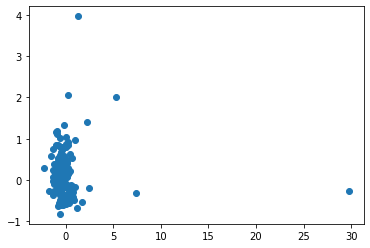

In [9]:
plt.scatter(X_pc[:,0], Y)
# print(X_pc[:,0].shape)
# print(Y.shape)
# print(Y)

## Transform Data to Polynomial Features, Train Models, and Plot Error

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

def limitDownsideTo1(arr):
    arr[arr < -1] = -1
    return arr

def trainAndGetResults(X, baseline=False):
    results = {'clf': [] , 'x': [], 'X_train': [], 'Y_pred': [], 'Y_pred_ltd': [], 'Y_test': [], 'mse': [], 'mse_ltd': [], 'rmse': [], 'rmse_ltd': []}
    for i in range(1, 5):
        if not baseline:
            # print("X Shape = ")
            # print(X.shape)
            poly = PolynomialFeatures(degree=i)
            poly_features = poly.fit_transform(X)
            X_train, X_test, Y_train, Y_test = train_test_split(poly_features, Y, test_size=0.33, random_state=42)

            clf = LinearRegression()
            # print("Poly Shape = ")
            # print(poly_features.shape)
            clf.fit(X_train, Y_train)
            Y_pred = clf.predict(X_test)
            Y_pred_ltd = limitDownsideTo1(Y_pred.copy())
            results['clf'].append(clf)
            results['X_train'].append(X_train)
            results['Y_pred'].append(Y_pred)
            results['Y_pred_ltd'].append(Y_pred_ltd)
            results['Y_test'].append(Y_test)

            mse = mean_squared_error(Y_test, Y_pred)
            mse_ltd = mean_squared_error(Y_test, Y_pred_ltd)
            rmse = mean_squared_error(Y_test, Y_pred, squared=False)
            rmse_ltd = mean_squared_error(Y_test, Y_pred_ltd, squared=False)
        else:
            mse = mean_squared_error(Y, Y_baseline)
            mse_ltd = mean_squared_error(Y, Y_baseline)
            rmse = mean_squared_error(Y, Y_baseline, squared=False)
            rmse_ltd = mean_squared_error(Y, Y_baseline, squared=False)

        results['x'].append(i)
        results['mse'].append(mse)
        results['mse_ltd'].append(mse_ltd)
        results['rmse'].append(rmse)
        results['rmse_ltd'].append(rmse_ltd)
    return results

trueBaseResults = trainAndGetResults(X)
baselineBaseResults = trainAndGetResults(X, baseline=True)
truePcResults = trainAndGetResults(X_pc)
baselinePcResults = trainAndGetResults(X_pc, baseline=True)

## Display Prediction Distribution Statistics

In [11]:
print("1-degree predictions")
pd.DataFrame(trueBaseResults['Y_pred'][0], columns=['prediction']).describe()

1-degree predictions


,prediction
count,51.000000
mean,-1.178627
std,7.906906
min,-56.024179
25%,-0.098209
50%,0.142189
75%,0.229827
max,1.557921


In [12]:
print("2-degree predictions")
pd.DataFrame(trueBaseResults['Y_pred'][1], columns=['prediction']).describe()

2-degree predictions


,prediction
count,51.000000
mean,-1.714181
std,7.583040
min,-46.579459
25%,-0.181961
50%,0.048090
75%,0.235836
max,3.279116


In [13]:
print("Test set statistics")
trueBaseResults['Y_test'][0]['percentage'].describe()

Test set statistics


count    51.000000
mean      0.355780
std       0.765610
min      -0.608630
25%      -0.188799
50%       0.212174
75%       0.801447
max       3.964539
Name: percentage, dtype: float64

## Limit Downside to -1 (-100%)

In [14]:
print("1-degree predictions adjusted")
pd.DataFrame(limitDownsideTo1(trueBaseResults['Y_pred'][0]), columns=['prediction']).describe()
# print(pd.DataFrame(degree1AdjustedY, columns=['prediction']))

1-degree predictions adjusted


,prediction
count,51.000000
mean,0.040658
std,0.459879
min,-1.000000
25%,-0.098209
50%,0.142189
75%,0.229827
max,1.557921


In [15]:
print("2-degree predictions adjusted")
pd.DataFrame(limitDownsideTo1(trueBaseResults['Y_pred'][1]), columns=['prediction']).describe()

2-degree predictions adjusted


,prediction
count,51.000000
mean,0.114569
std,0.769613
min,-1.000000
25%,-0.181961
50%,0.048090
75%,0.235836
max,3.279116


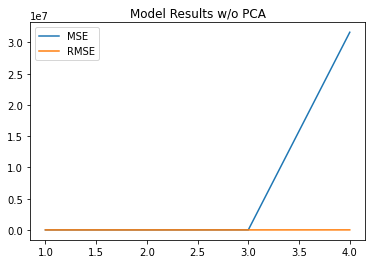

MSEs: [64.02841200682086, 59.68751214567978, 11306.21560959224, 31637091.337192934]
RMSEs: [8.00177555338944, 7.725769356231118, 106.3306898764051, 5624.685887869023]


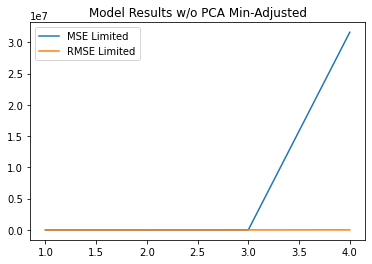

Limited MSEs: [0.9025238833528825, 1.2124661619440271, 7217.371902004976, 31605597.51593874]
Limited RMSEs: [0.9500125701025658, 1.101120412100342, 84.95511698541164, 5621.885583675528]

1's top 3 weights were [1.89756608 0.52665091 0.43057483]
at [ 5  7 15]
2's top 3 weights were [1.48937650e-06 2.17916215e-07 1.26427052e-07]
at [222  37 220]
3's top 3 weights were [3.26653931e-16 3.10894728e-16 2.92305815e-16]
at [1783 2702 1382]
4's top 3 weights were [5.22727489e-26 4.34235901e-26 4.33828024e-26]
at [18092  2923 20466]


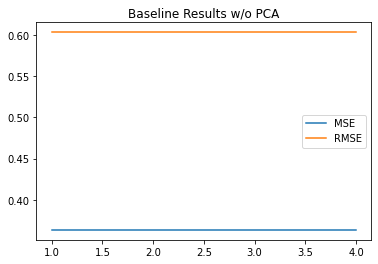

MSEs: [0.3636408908445594, 0.3636408908445594, 0.3636408908445594, 0.3636408908445594]
RMSEs: [0.6030264429065773, 0.6030264429065773, 0.6030264429065773, 0.6030264429065773]


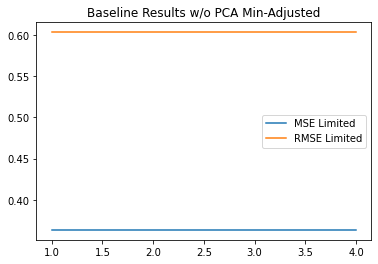

Limited MSEs: [0.3636408908445594, 0.3636408908445594, 0.3636408908445594, 0.3636408908445594]
Limited RMSEs: [0.6030264429065773, 0.6030264429065773, 0.6030264429065773, 0.6030264429065773]



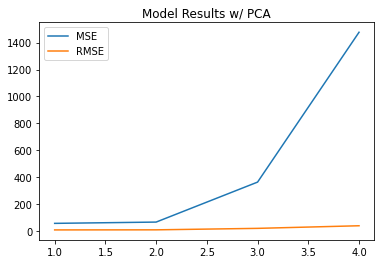

MSEs: [56.21568368078722, 65.74301779467595, 363.05306555630574, 1477.3449193994072]
RMSEs: [7.49771189635793, 8.10820681745822, 19.053951442058043, 38.43624486600385]


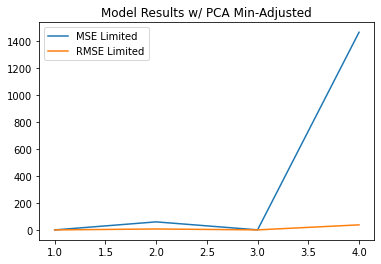

Limited MSEs: [0.8900635889338172, 60.34756989727427, 1.4159512134805536, 1462.642826087191]
Limited RMSEs: [0.9434318146712126, 7.768369835253357, 1.189937483013521, 38.24451367303801]

1's top 3 weights were [1.26798252 1.10429247 0.77403783]
at [10 12 13]
2's top 3 weights were [1.29796128 1.20335141 1.16699276]
at [199 196  18]
3's top 3 weights were [0.20650708 0.17384607 0.17263851]
at [  90 1471   13]
4's top 3 weights were [0.09541428 0.08313761 0.07546774]
at [90 13 69]


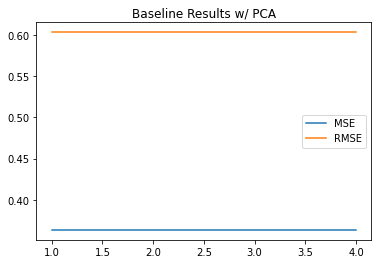

MSEs: [0.3636408908445594, 0.3636408908445594, 0.3636408908445594, 0.3636408908445594]
RMSEs: [0.6030264429065773, 0.6030264429065773, 0.6030264429065773, 0.6030264429065773]


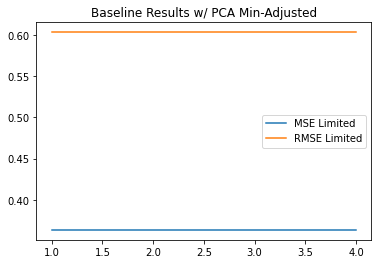

Limited MSEs: [0.3636408908445594, 0.3636408908445594, 0.3636408908445594, 0.3636408908445594]
Limited RMSEs: [0.6030264429065773, 0.6030264429065773, 0.6030264429065773, 0.6030264429065773]



In [16]:
def plotResults(results, title):
    plt.title(title)
    plt.plot(results['x'], results['mse'], label = "MSE")
    plt.plot(results['x'], results['rmse'], label = "RMSE")
    plt.legend()
    plt.show()
    print("MSEs: {}".format(results['mse']))
    print("RMSEs: {}".format(results['rmse']))

    plt.title(title + " Min-Adjusted")
    plt.plot(results['x'], results['mse_ltd'], label = "MSE Limited")
    plt.plot(results['x'], results['rmse_ltd'], label = "RMSE Limited")
    plt.legend()
    plt.show()
    print("Limited MSEs: {}".format(results['mse_ltd']))
    print("Limited RMSEs: {}".format(results['rmse_ltd']))
    print()
    for x, clf in zip(results['x'], results['clf']):
        coef = clf.coef_.ravel()
        max_3_idx = coef.argsort()[-3:][::-1]
        print("{}'s top 3 weights were {}".format(x, coef[max_3_idx]))
        print("at {}".format(max_3_idx))

plotResults(trueBaseResults, "Model Results w/o PCA")
plotResults(baselineBaseResults, "Baseline Results w/o PCA")
plotResults(truePcResults, "Model Results w/ PCA")
plotResults(baselinePcResults,"Baseline Results w/ PCA")


## Train Neural Net Model

In [17]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression

import NNModels
imp.reload(NNModels)
from NNModels import NeuralNetRegressionModel as NNRegModel

trueBaseResultsNN = NNRegModel.trainAndGetResults(X, Y, Y_baseline)
baselineBaseResultsNN = NNRegModel.trainAndGetResults(X, Y, Y_baseline, baseline=True)
truePcResultsNN = NNRegModel.trainAndGetResults(X_pc, Y, Y_baseline)
baselinePcResultsNN = NNRegModel.trainAndGetResults(X_pc, Y, Y_baseline, baseline=True)

X Shape = 
(152, 24)
X Shape = 
(152, 23)


In [18]:
import NNModels
imp.reload(NNModels)
from NNModels import NeuralNetClassificationModel as NNClfModel

Y_clf = NNClfModel.getYClassificationFromMerged(merged)
Y_clf_baseline = NNClfModel.getYBaselineClassificationFromMerged(merged)

# print(merged)

trueBaseResultsNNClf = NNClfModel.trainAndGetResults(X, Y_clf, Y_clf_baseline)
baselineBaseResultsNNClf = NNClfModel.trainAndGetResults(X, Y_clf, Y_clf_baseline, baseline=True)
truePcResultsNNClf = NNClfModel.trainAndGetResults(X_pc, Y_clf, Y_clf_baseline)
baselinePcResultsNNClf = NNClfModel.trainAndGetResults(X_pc, Y_clf, Y_clf_baseline, baseline=True)

X Shape = 
(152, 24)
{'alpha': 0.1, 'epsilon': 1e-08, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.05}
X Shape = 
(152, 23)
{'alpha': 1e-05, 'epsilon': 1e-08, 'hidden_layer_sizes': (5, 20), 'learning_rate_init': 0.05}


## Plot Neural Net Model

In [19]:
def plotResultsNN(results, title):
    plt.title(title)
    plt.plot(results['x'], results['mse'], label = "MSE")
    plt.plot(results['x'], results['rmse'], label = "RMSE")
    plt.legend()
    plt.show()
    print("MSEs: {}".format(results['mse']))
    print("RMSEs: {}".format(results['rmse']))
    print()

NNRegModel.plotResults(trueBaseResultsNN, "NN Reg Model Results w/o PCA")
NNRegModel.plotResults(baselineBaseResultsNN, "Baseline Results w/o PCA")
NNRegModel.plotResults(truePcResultsNN, "NN Reg Model Results w/ PCA")
NNRegModel.plotResults(baselinePcResultsNN,"Baseline Results w/ PCA")

NN Reg Model Results w/o PCA
MSEs: [84420903162.36116]
RMSEs: [290552.7545255098]

Baseline Results w/o PCA
MSEs: [0.3636408908445594]
RMSEs: [0.6030264429065773]

NN Reg Model Results w/ PCA
MSEs: [0.8819264492224909]
RMSEs: [0.939109391510111]

Baseline Results w/ PCA
MSEs: [0.3636408908445594]
RMSEs: [0.6030264429065773]



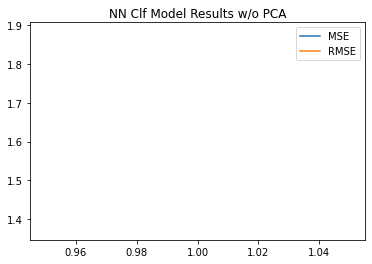

NN Clf Model Results w/o PCA
MSEs: [1.8823529411764706]
RMSEs: [1.3719886811400708]



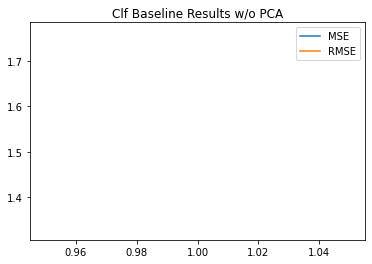

Clf Baseline Results w/o PCA
MSEs: [1.763157894736842]
RMSEs: [1.3278395591097751]



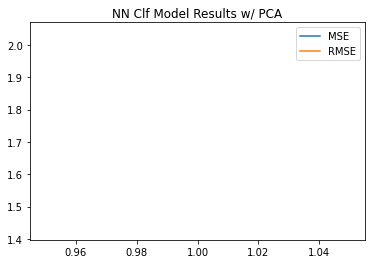

NN Clf Model Results w/ PCA
MSEs: [2.0392156862745097]
RMSEs: [1.4280110945908333]



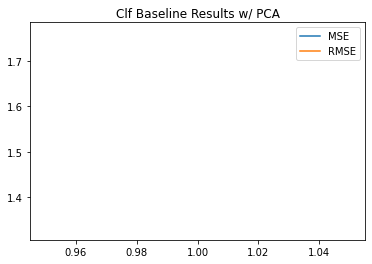

Clf Baseline Results w/ PCA
MSEs: [1.763157894736842]
RMSEs: [1.3278395591097751]



In [20]:
# plot classification model results
NNClfModel.plotResults(trueBaseResultsNNClf, "NN Clf Model Results w/o PCA")
NNClfModel.plotResults(baselineBaseResultsNNClf, "Clf Baseline Results w/o PCA")
NNClfModel.plotResults(truePcResultsNNClf, "NN Clf Model Results w/ PCA")
NNClfModel.plotResults(baselinePcResultsNNClf,"Clf Baseline Results w/ PCA")

## Real-World Results

In [21]:
# Collect data from 10 different stocks
final_tickers = ['AAPL', 'MSFT', 'AMZN', 'FB', 'GOOGL', 'TSLA', 'JPM', 'JNJ']
#- final_pca = PCA(n_components=21)
# final_pca = PCA(n_components='mle')
print("components = " + str(pca.n_components_))
final_pca = PCA(n_components=pca.n_components_)
final_poly = PolynomialFeatures(degree=1)

spy_X = api.getSamplesFromTickers(final_tickers, samplesPerTicker=50, maxTickers=10)
spy_Y = api.getYFromDF(spy_X)

components = 23

Getting X data...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Ticker didn't have enough data.
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...
Making API call request...

Getting Y data...
Making API call request...
Date 2001-12-29 not found for AAPL
Date 2015-12-26 not found for AAPL
Date 2017-12-30 not found for AAPL
Date 2010-06-26 not found for AAPL
Date 2014-09-27 not found for AAPL
Date 1991-03-31 not found for AA

In [22]:
print(api.getNumApiCalls())

151


In [23]:
spy_merged = pd.merge(spy_X, spy_Y, how='inner', left_on=["date", "symbol"], right_on=["date", "symbol"]).dropna()
spy_X = spy_merged.drop(['date', 'symbol', 'futureDate', 'futureClose', 'percentage'], axis=1)
spy_Y = spy_merged[['percentage']]

spy_X_scaled = pd.DataFrame(ss.fit_transform(spy_X), columns = spy_X.columns)
spy_X_pc = final_pca.fit_transform(spy_X_scaled)
spy_X_poly = final_poly.fit_transform(spy_X_scaled)
spy_X_pc_poly = final_poly.fit_transform(spy_X_pc)

In [24]:
# get classification test data
spy_Y_clf = NNClfModel.getYClassificationFromMerged(spy_merged)
spy_Y_clf_baseline = NNClfModel.getYBaselineClassificationFromMerged(spy_merged)

# print(spy_merged)
# print(spy_X.shape)
# print(spy_Y.shape)

In [25]:
display(spy_X.head())

print(spy_X.shape)
print(spy_Y.shape)

,currentRatio,quickRatio,grossProfitMargin,operatingProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,debtEquityRatio,priceToBookRatio,priceToSalesRatio,...,growthCostOfRevenue,growthGrossProfit,growthGrossProfitRatio,growthOperatingExpenses,growthEBITDA,growthOperatingIncome,growthNetIncome,growthEPS,marketCapitalization,enterpriseValue
0,1.869350,0.790864,0.347691,-0.164715,-0.039492,-0.093195,-0.114835,1.359812,2.244632,2.435703,...,0.019130,-0.056921,-0.044308,0.038228,-0.243754,-0.297757,-0.312461,-0.313440,4.535280e+09,4.450280e+09
1,2.938776,1.356137,0.941085,0.488778,0.082613,0.114079,0.171666,0.380885,11.806110,33.615027,...,0.243421,0.194225,-0.002331,0.002764,0.368163,0.450509,0.406208,0.375000,1.078370e+11,1.039850e+11
2,2.919154,1.089814,0.948157,0.556703,0.065992,0.087829,0.121756,0.330897,15.350344,70.186323,...,1.000000,0.224052,-0.020114,0.124491,0.280525,0.305318,0.178253,0.176471,3.465801e+11,3.404671e+11
3,3.959946,3.614008,0.880549,0.363012,0.079586,0.095805,0.134975,0.203785,8.917579,23.983628,...,0.179177,0.200067,0.002116,0.215088,0.203950,0.179283,0.175056,0.175056,1.955625e+10,1.876485e+10
4,1.535038,1.339796,0.826069,0.305037,0.062024,0.116845,0.100849,0.883874,7.033409,18.274018,...,-0.290432,-0.068933,0.054294,0.187293,-0.290290,-0.319704,-0.067771,-0.062363,2.641327e+11,2.523127e+11


(103, 24)
(103, 1)


In [26]:
# print(truePcResults['clf'][0])
print(spy_X_poly.shape)
print(spy_X_pc_poly.shape)

(103, 25)
(103, 24)


In [27]:
r1 = trueBaseResults['clf'][0].predict(spy_X_poly)
r2 = truePcResults['clf'][0].predict(spy_X_pc_poly)

r1MSE = mean_squared_error(spy_Y, r1)
r2MSE = mean_squared_error(spy_Y, r2)
baseMSE = mean_squared_error(spy_Y, np.full((spy_X.shape[0]), .06))

print(r1MSE)
print(r2MSE)
print(baseMSE)

10.032235272949016
21.698494725302194
1.254020795579358


In [28]:
# test neural net results for regression model

r1 = trueBaseResultsNN['clf'][0].predict(spy_X_poly)
# r2 = truePcResultsNN['clf'][0].predict(spy_X_pc_poly)
r2 = truePcResultsNN['clf'][-1].predict(spy_X_pc_poly)

r1MSE_NN = mean_squared_error(spy_Y, r1)
r2MSE_NN = mean_squared_error(spy_Y, r2)
baseMSE = mean_squared_error(spy_Y, np.full((spy_X.shape[0]), .06))

print(r1MSE_NN)
print(r2MSE_NN)
print(baseMSE)

12.327903308272973
1.6653258675160478
1.254020795579358


In [29]:
# test neural net results for classification model

import NNModels
imp.reload(NNModels)
from NNModels import NeuralNetClassificationModel as NNClfModel

# print(spy_Y_clf)
# print(spy_Y_clf_baseline)

r1 = trueBaseResultsNNClf['clf'][0].predict(spy_X_poly)
r2 = truePcResultsNNClf['clf'][-1].predict(spy_X_pc_poly)

r1MSE_NN = mean_squared_error(spy_Y_clf, r1)
r2MSE_NN = mean_squared_error(spy_Y_clf, r2)
baseMSE = mean_squared_error(spy_Y_clf, spy_Y_clf_baseline)

print(r1MSE_NN)
print(r2MSE_NN)
print(baseMSE)

1.3203883495145632
2.563106796116505
1.0097087378640777


In [30]:
# test neural net results for classification model Pt. 2 
# this is just a little experiment to see if we can use a binary classifier to
# predict the price change percentage

import NNModels
imp.reload(NNModels)
from NNModels import NeuralNetClassificationModel as NNClfModel

r1 = NNClfModel.predict(trueBaseResultsNNClf['clf'][0], spy_X_poly)
r2 = NNClfModel.predict(truePcResultsNNClf['clf'][-1], spy_X_pc_poly)

r1MSE_NN = mean_squared_error(spy_Y, r1)
r2MSE_NN = mean_squared_error(spy_Y, r2)
baseMSE = mean_squared_error(spy_Y, np.full((spy_X.shape[0]), .06))

print(r1MSE_NN)
print(r2MSE_NN)
print(baseMSE)

1.2719745117704928
1.2867180315507882
1.254020795579358
